# RECOMMENDER SYSTEM 

In [1]:
#General Purpose Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
sns.set()

#Recommender System
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# Note on Data:

The data and example on this Notebook came from Kaggle and you can find it in the following link: [Music Recommendations](https://www.kaggle.com/code/dhanyashreegh/music-recommendation-systems/notebook)

## Data Exploration

In [2]:
# Load the dataset with triplets of user_id, song_id, and listening frequency
df_triplets = pd.read_csv('./data_kaggle/kaggle_visible_evaluation_triplets.txt',
                         sep='\t', names=['user_id', 'song_id', 'freq'])

In [3]:
# Load the dataset with track_id, song_id, artist_name, and song title
df_tracks = pd.read_csv('./data_kaggle/unique_tracks.txt', 
                        sep='<SEP>', names=['track_id', 'song_id', 'artist_name', 'song'])

In [4]:
# Merge the datasets on 'song_id'
merged_data = pd.merge(df_triplets, df_tracks.drop_duplicates(['song_id']), on='song_id', how='left')

In [5]:
merged_data.drop(columns='track_id', axis=1, inplace=True)

In [6]:
merged_data.shape

(1450933, 5)

In [7]:
merged_data.head()

,user_id,song_id,freq,artist_name,song
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,Dwight Yoakam,You're The One
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1,Cartola,Tive Sim
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1,Lonnie Gordon,Catch You Baby (Steve Pitron & Max Sanna Radio...
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1,Miguel Calo,El Cuatrero


In [8]:
data = merged_data.copy()

In [9]:
# Dropping the row that contains missing value 
data.dropna(inplace=True)

In [10]:
print('Total Data points :' ,data.shape[0])
print('No. of unique Users :', data['user_id'].unique().shape[0])
print('No. of unique Songs :', data['song_id'].unique().shape[0])
print('\nNo. of unique Artists :', data['artist_name'].unique().shape[0])
print('No. of unique Song Releases :', data['song'].unique().shape[0])

Total Data points : 1450932
No. of unique Users : 110000
No. of unique Songs : 163205

No. of unique Artists : 28360
No. of unique Song Releases : 137622


In [11]:
data.tail()

,user_id,song_id,freq,artist_name,song
1450928,5e650759ebf89012044c6d52121eeada8b0ec814,SOVLNXV12A6D4F706E,1,Mos Def,Ms. Fat Booty
1450929,5e650759ebf89012044c6d52121eeada8b0ec814,SOVDSJC12A58A7A271,2,Sam Cooke,Ain't Misbehavin
1450930,5e650759ebf89012044c6d52121eeada8b0ec814,SOBRHVR12A8C133F35,2,Southside Spinners,Luvstruck
1450931,5e650759ebf89012044c6d52121eeada8b0ec814,SOMGVYU12A8C1314FF,2,J. Karjalainen & Mustat Lasit,Sinisten tähtien alla
1450932,5e650759ebf89012044c6d52121eeada8b0ec814,SOTCMDJ12A6D4F8528,3,Angels and Airwaves,The Gift


## Step 1: Data Preprocessing - ETL

In [12]:
# Create numerical mappings for 'user_id' and 'song_id'
user_ids = data['user_id'].unique().tolist()
song_ids = data['song_id'].unique().tolist()

In [13]:
# Assuming 'data' is your DataFrame with columns 'user_id', 'song_id', and 'freq'
user_to_index = {user_id: index for index, user_id in enumerate(data['user_id'].unique())}
song_to_index = {song_id: index for index, song_id in enumerate(data['song_id'].unique())}
index_to_song = {index: song_id for song_id, index in song_to_index.items()}

# Map users and songs to their respective indices
data['user_index'] = data['user_id'].map(user_to_index)
data['song_index'] = data['song_id'].map(song_to_index)

# Create the interaction matrix
interaction_matrix_csr = csr_matrix((data['freq'], (data['user_index'], data['song_index'])), shape=(len(user_to_index), len(song_to_index)))

## Step 2: Data Exploration

### Artist

In [14]:
df = data[['artist_name','song','freq']]
artist_pop = df.pivot_table(values=['freq'],index = 'artist_name' ,aggfunc = 'count')
artist_pop = artist_pop.sort_values(by='freq',ascending=False)
artist_pop = artist_pop.reset_index()
artist_pop.rename(columns = {'artist_name':'Artist', 'freq':'Total User'}, inplace = True)

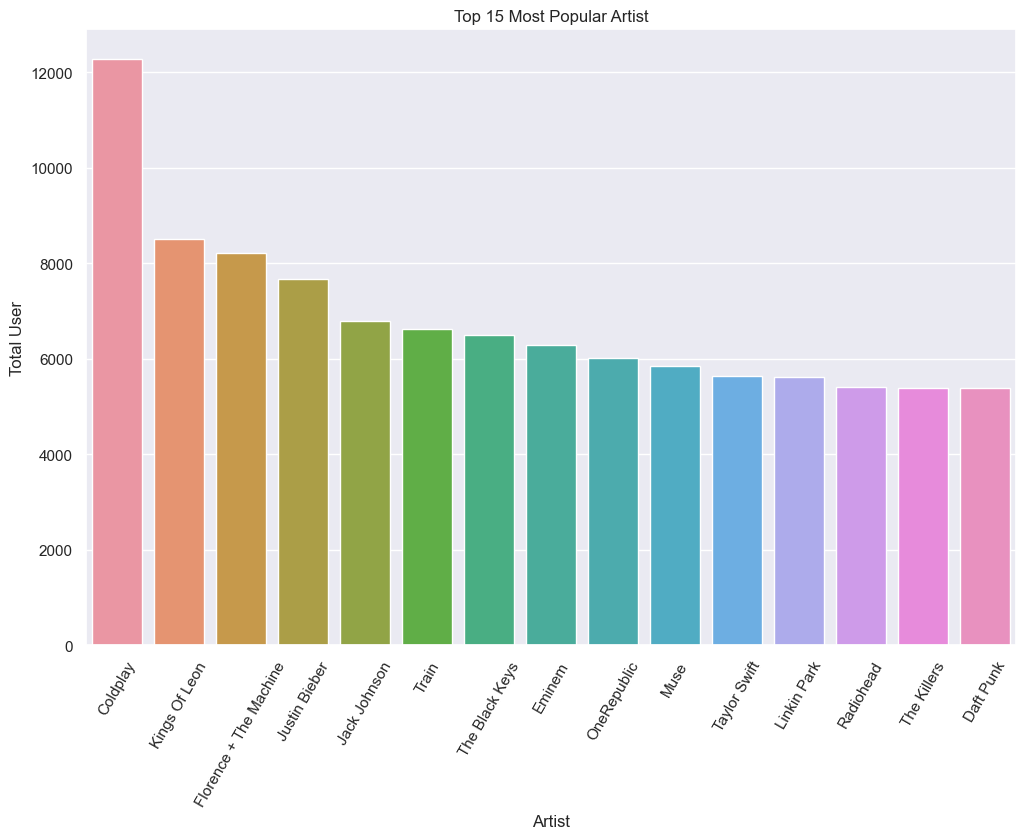

In [15]:
# Plotting Barplot for top 15 most popular artist
plt.figure(figsize=(12,8))
sns.barplot(x=artist_pop['Artist'][:15],y=artist_pop['Total User'][:15])
plt.title('Top 15 Most Popular Artist')
plt.xticks(rotation=60)
plt.show()

In [16]:
# Number of Songs Released by Top 15 Most Popular Artist
artist_pop = artist_pop.sort_values(by='Total User',ascending=False)
artists = artist_pop['Artist'][:15]
song_count = []
for col in artists:
    x = data[data['artist_name'] == col].song.nunique()
    song_count.append(x)

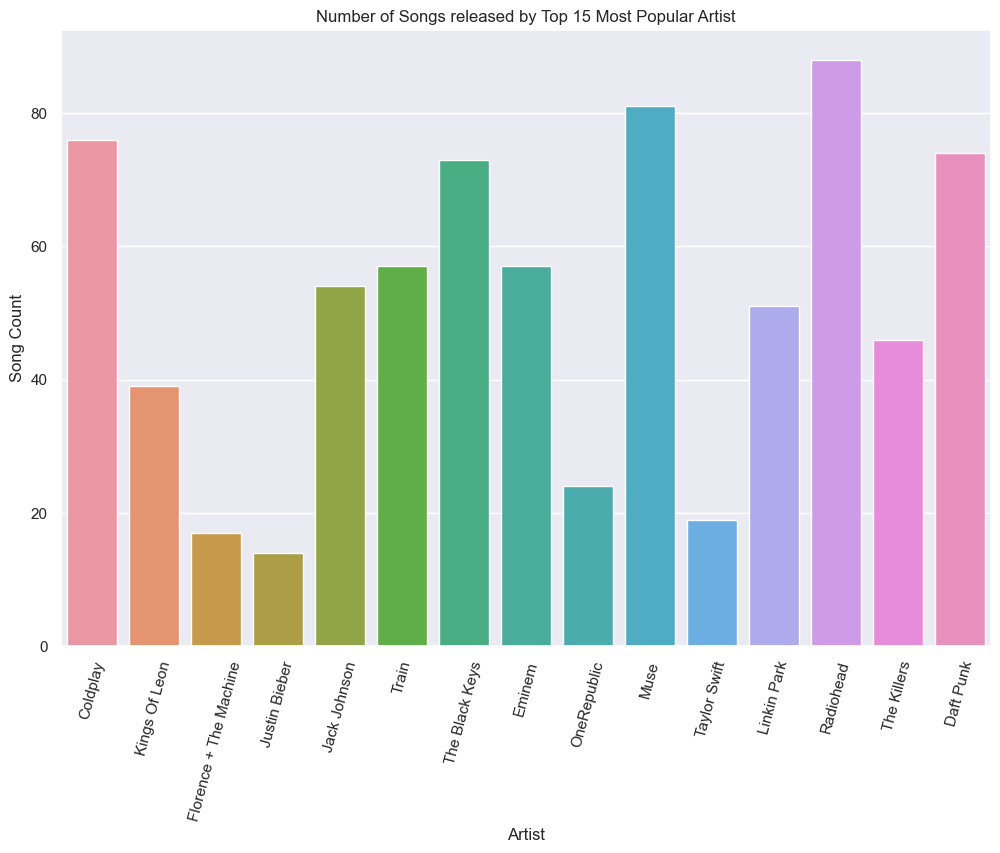

In [17]:
# Visualization
plt.figure(figsize=(12,8))
sns.barplot(x=artists,y=song_count)
plt.title('Number of Songs released by Top 15 Most Popular Artist')
plt.xlabel('Artist')
plt.ylabel('Song Count')
plt.xticks(rotation=75)
plt.show()

In [18]:
# Top-15 Artists who have Highest Song Frequency
artist_freq = data.groupby(['artist_name'],sort=True)['freq'].sum().nlargest(15)

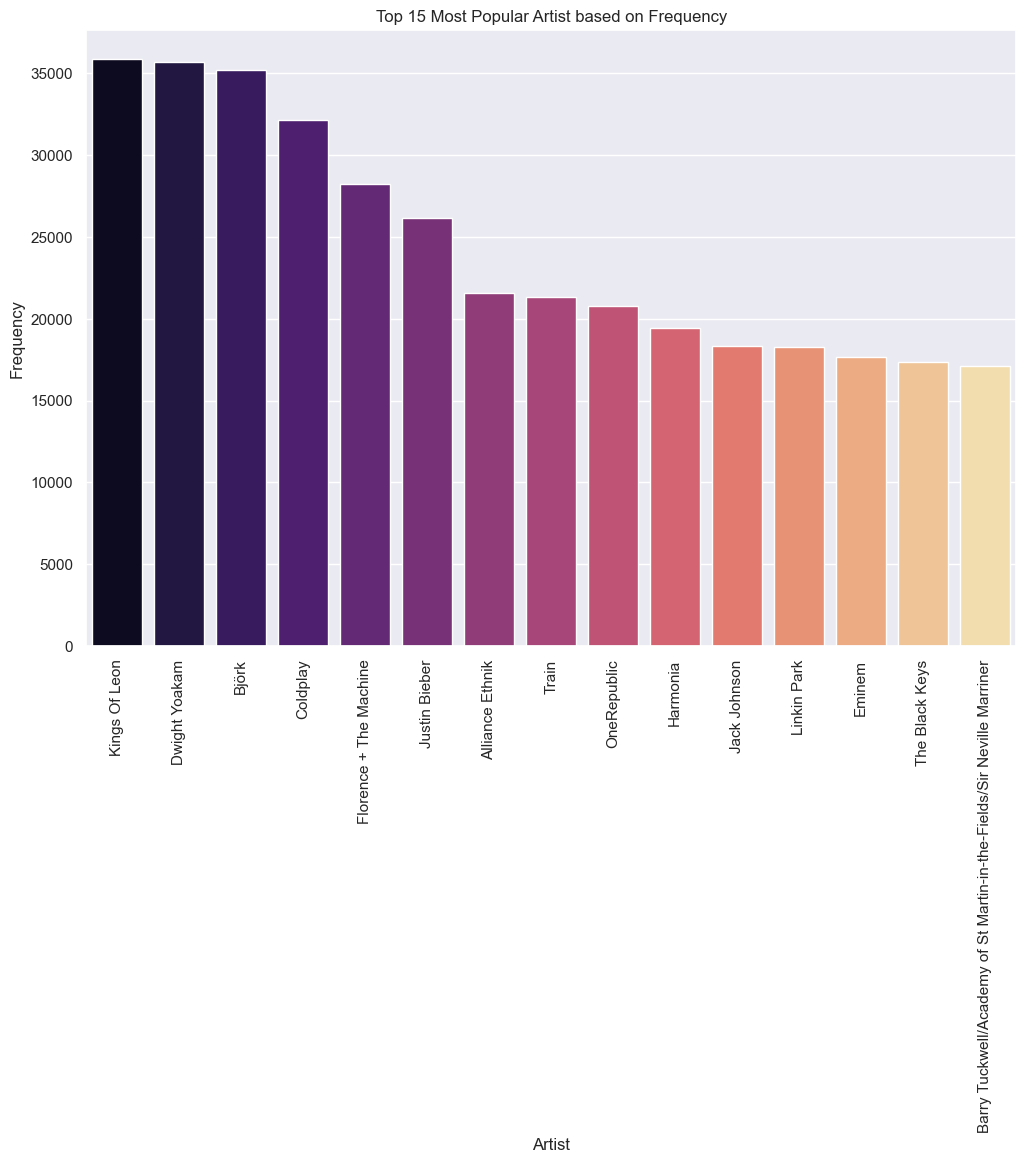

In [19]:
# Visualization
plt.figure(figsize=(12,8))
index = artist_freq.keys()
sns.barplot(x=index, y=artist_freq, palette='magma')
plt.title('Top 15 Most Popular Artist based on Frequency')
plt.xlabel('Artist')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

### Songs

In [20]:
df = data[['artist_name','song','freq']]
song_pop = df.pivot_table(values=['freq'],index = 'song' ,aggfunc = 'count')
song_pop = song_pop.sort_values(by='freq',ascending=False)
song_pop = song_pop.reset_index()
song_pop.rename(columns = {'song':'Song', 'freq':'Total User'}, inplace = True)

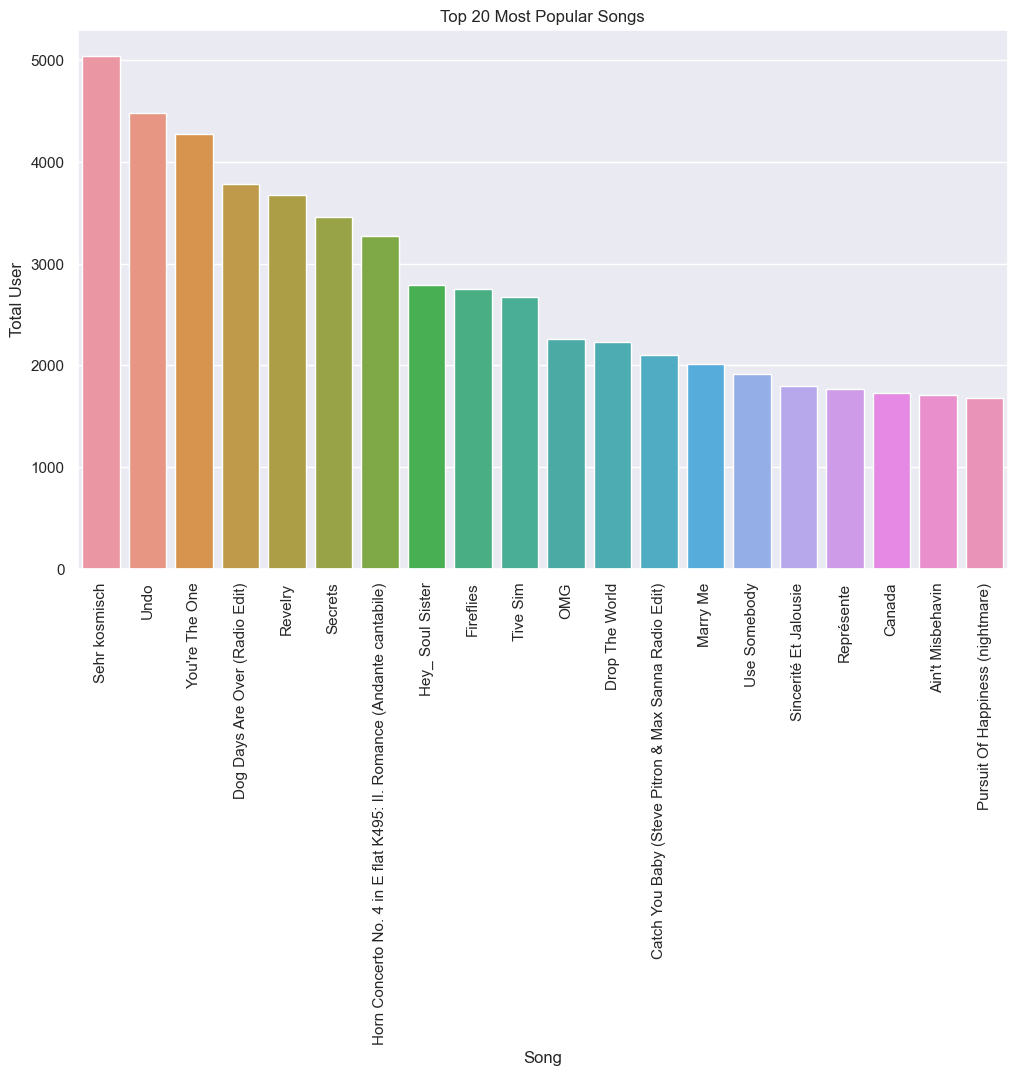

In [21]:
# Visualization
plt.figure(figsize=(12,7))
sns.barplot(x=song_pop['Song'][:20],y=song_pop['Total User'][:20])
plt.title('Top 20 Most Popular Songs')
plt.xticks(rotation=90)
plt.show()

In [22]:
song_count = data['song_id'].value_counts()
s_id = data['song_id'].value_counts().keys()
song, p_count, artist = [], [], []
for i in range(20):
    count = data['freq'][data['song_id'] == s_id[i]].sum()
    artist.append(data['artist_name'][data['song_id'] == s_id[i]].value_counts().keys()[0])
    song.append(data['song'][data['song_id'] == s_id[i]].value_counts().keys()[0])
    p_count.append(count)
    
song_dict = {'Artist_name':artist, 'Song_name':song, 'Play_count':p_count}
top_songs = pd.DataFrame(song_dict)
top_songs.sort_values(by=['Play_count'],ascending=False,inplace=True)

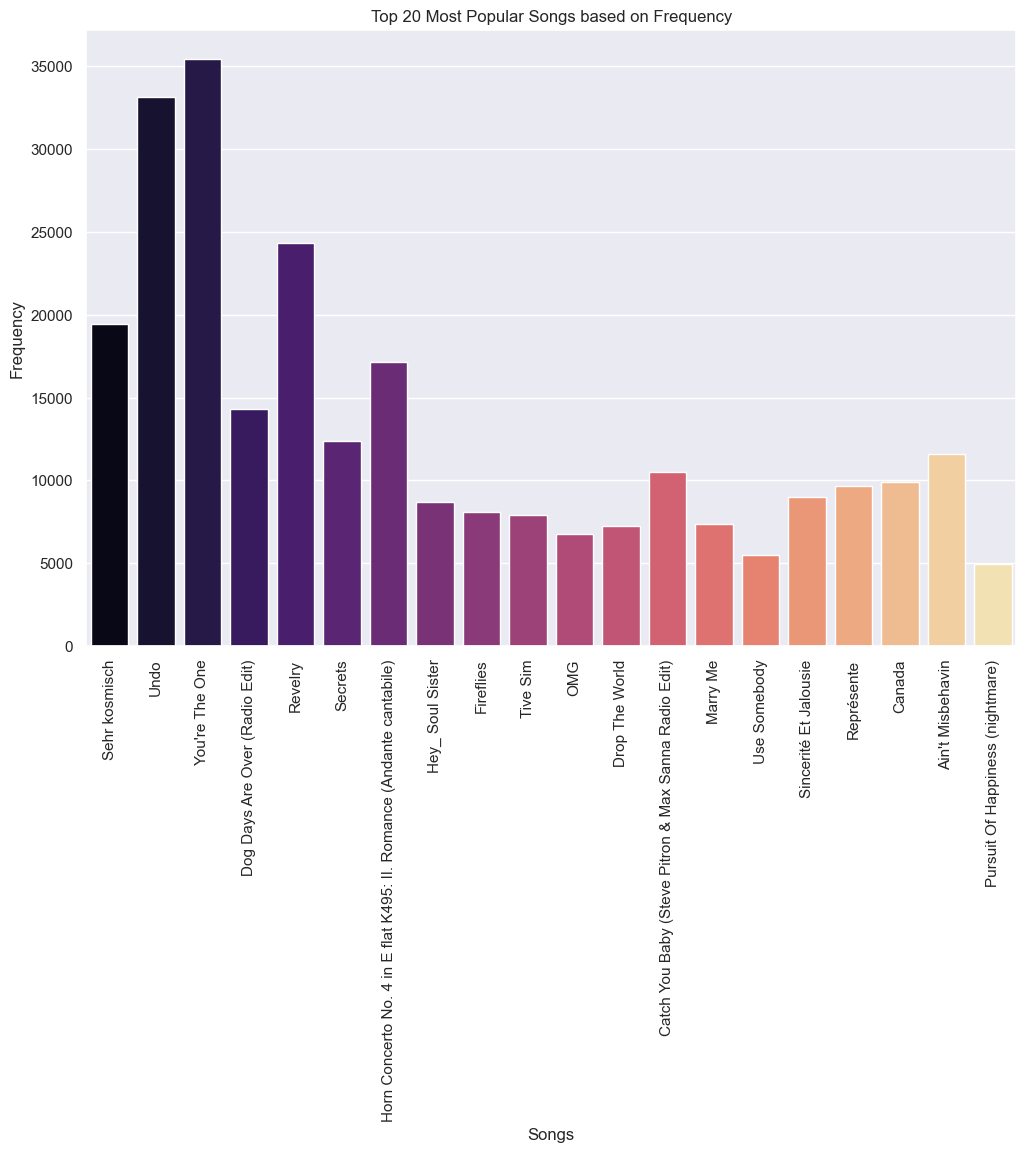

In [23]:
# Visualization
plt.figure(figsize=(12,8))
sns.barplot(x=song, y=p_count, palette='magma')
plt.title('Top 20 Most Popular Songs based on Frequency')
plt.xlabel('Songs')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

## Step 3: Data Splitting

In [24]:
# Decide on a 'like' threshold
like_threshold = data['freq'].quantile(0.75)  # Adjust based on your data

# Split the data into 'likes' and 'dislikes'
likes_data = data[data['freq'] >= like_threshold]
dislikes_data = data[data['freq'] < like_threshold]

# Further split 'likes' data into training and test sets
likes_train, likes_test = train_test_split(likes_data, test_size=0.2, random_state=42)

# Combine 'likes' training data with 'dislikes' to form the full training set
full_train_data = pd.concat([likes_train, dislikes_data])

## Step 4: Model Preparation

### Similarity Matrices

In [25]:
# Calculate similarity matrix for users
user_similarity_matrix_csr = cosine_similarity(interaction_matrix_csr, dense_output=False)

# Calculate similarity matrix for items
item_similarity_matrix_csr = cosine_similarity(interaction_matrix_csr.T, dense_output=False)

In [26]:
# Create a CSR matrix for the full training set
train_interaction_matrix_csr = csr_matrix((full_train_data['freq'],
                                           (full_train_data['user_index'], full_train_data['song_index'])),
                                          shape=(len(user_to_index), len(song_to_index)))

# Create a CSR matrix for the test set
test_interaction_matrix_csr = csr_matrix((likes_test['freq'],
                                          (likes_test['user_index'], likes_test['song_index'])),
                                         shape=(len(user_to_index), len(song_to_index)))

## Step 5: Models

### FIRST Hybrid Recommendation Logic Cosine Similarity

In [27]:
class HybridRecommender:
    def __init__(self, user_similarity_matrix, item_similarity_matrix, interaction_matrix_csr, song_to_index, index_to_song):
        self.user_similarity_matrix = user_similarity_matrix
        self.item_similarity_matrix = item_similarity_matrix
        self.interaction_matrix_csr = interaction_matrix_csr
        self.song_to_index = song_to_index
        self.index_to_song = index_to_song

    def recommend_for_user(self, user_id, top_n=10):
        user_index = user_to_index[user_id]
        user_similarities = self.user_similarity_matrix[user_index].toarray().ravel()
        similar_users_indices = user_similarities.argsort()[-top_n:][::-1]
        combined_scores = self.interaction_matrix_csr[similar_users_indices].sum(axis=0)

        # Check if combined_scores is a sparse matrix and convert it to a dense array if so
        if isinstance(combined_scores, np.matrix):
            combined_scores = combined_scores.A1  # Convert matrix to 1D array
        elif isinstance(combined_scores, scipy.sparse.spmatrix):
            combined_scores = combined_scores.toarray().ravel()
        else:
            combined_scores = combined_scores.ravel()  # It's already a dense array or matrix

        recommended_item_indices = np.argsort(combined_scores)[-top_n:][::-1]
        recommended_song_ids = [self.index_to_song[idx] for idx in recommended_item_indices]
        recommended_songs = [data.loc[data['song_id'] == song_id, 'song'].iloc[0] for song_id in recommended_song_ids]
        recommendations_df = pd.DataFrame({'user_id': user_id, 'recommended_song': recommended_songs})
        return recommendations_df

    def recommend_similar_songs(self, song_id, top_n=10):
        song_index = self.song_to_index[song_id]
        song_similarities = self.item_similarity_matrix[song_index].toarray().ravel()
        similar_songs_indices = song_similarities.argsort()[-top_n:][::-1]
        similar_song_ids = [self.index_to_song[idx] for idx in similar_songs_indices]
        similar_songs = [data.loc[data['song_id'] == song_id, 'song'].iloc[0] for song_id in similar_song_ids]
        recommendations_df = pd.DataFrame({'song_id': song_id, 'similar_song': similar_songs})
        return recommendations_df

    def recommend_for_new_user(self, liked_song_ids, top_n=10):
        liked_indices = [self.song_to_index[song_id] for song_id in liked_song_ids]
        new_user_profile = np.mean(self.interaction_matrix_csr[:, liked_indices], axis=1)

        # Check if new_user_profile is a sparse matrix and convert it to a dense array if so
        if isinstance(new_user_profile, np.matrix):
            new_user_profile = new_user_profile.A1  # Convert matrix to 1D array
        elif isinstance(new_user_profile, scipy.sparse.spmatrix):
            new_user_profile = new_user_profile.toarray().ravel()
        else:
            new_user_profile = new_user_profile.ravel()  # It's already a dense array or matrix

        recommended_item_indices = np.argsort(new_user_profile)[-top_n:][::-1]
        recommended_song_ids = [self.index_to_song[idx] for idx in recommended_item_indices]
        recommended_songs = [data.loc[data['song_id'] == song_id, 'song'].iloc[0] for song_id in recommended_song_ids]
        recommendations_df = pd.DataFrame({'new_user': 'New_User', 'recommended_song': recommended_songs})
        return recommendations_df

    def update_user_preferences(self, user_id, liked_song_ids, top_n=10):
        user_index = user_to_index[user_id]
        liked_indices = [self.song_to_index[song_id] for song_id in liked_song_ids]
        # Update user's interaction vector with high frequency for liked songs
        user_interaction_vector = self.interaction_matrix_csr[user_index].toarray().ravel()
        user_interaction_vector[liked_indices] = user_interaction_vector[liked_indices] + 100  # Arbitrary high value to denote preference
        recommended_item_indices = np.argsort(user_interaction_vector)[-top_n:][::-1]
        recommended_song_ids = [self.index_to_song[idx] for idx in recommended_item_indices]
        recommended_songs = [data.loc[data['song_id'] == song_id, 'song'].iloc[0] for song_id in recommended_song_ids]
        recommendations_df = pd.DataFrame({'user_id': user_id, 'new_preference': recommended_songs})
        return recommendations_df
    
    def generate_recommendations_for_user(self, user_id, top_n=10):
        # This method should generate top_n recommendations for the user
        # We can use the existing `recommend_for_user` for this purpose
        return self.recommend_for_user(user_id, top_n=top_n)['recommended_song'].tolist()

    def recommend(self, user_id=None, song_id=None, top_n=10, new_user_songs=None, additional_likes=None):
        if user_id and not song_id and not new_user_songs and not additional_likes:
            # User-based recommendations
            return self.recommend_for_user(user_id, top_n)
        elif song_id and not user_id and not new_user_songs and not additional_likes:
            # Item-based recommendations
            return self.recommend_similar_songs(song_id, top_n)
        elif new_user_songs and not user_id and not song_id and not additional_likes:
            # Cold-start recommendations for a new user
            return self.recommend_for_new_user(new_user_songs, top_n)
        elif user_id and additional_likes and not song_id and not new_user_songs:
            # Update user profile and recommend
            return self.update_user_preferences(user_id, additional_likes, top_n)
        else:
            # Handle other scenarios or raise an error for insufficient information
            raise ValueError("Insufficient information for recommendations.")

In [28]:
def evaluate_precision_recall(hybrid_recommender, test_data, top_n=10):
    # This function will evaluate Precision@k and Recall@k
    user_precisions = []
    user_recalls = []

    # Loop over each user in the test set
    for user_id in test_data['user_id'].unique():
        # Get the 'true' songs liked by the user from test set
        true_likes = test_data[test_data['user_id'] == user_id]['song_id'].tolist()

        # Generate recommendations for the user
        recommendations = hybrid_recommender.generate_recommendations_for_user(user_id, top_n=top_n)

        # Calculate precision and recall
        true_positives = len(set(recommendations) & set(true_likes))
        precision = true_positives / top_n
        recall = true_positives / len(true_likes) if true_likes else 0

        user_precisions.append(precision)
        user_recalls.append(recall)

    # Average precision and recall across all users
    mean_precision = np.mean(user_precisions)
    mean_recall = np.mean(user_recalls)

    return mean_precision, mean_recall

## Step 6: Making Recommendations

In [29]:
hybrid_recommender = HybridRecommender(user_similarity_matrix_csr, 
                                       item_similarity_matrix_csr, 
                                       interaction_matrix_csr,
                                       song_to_index, 
                                       index_to_song)

In [30]:
user_id_example = 'fd50c4007b68a3737fe052d5a4f78ce8aa117f3d'
song1 = 'SOVLNXV12A6D4F706E'
song2 = 'SOVDSJC12A58A7A271' 

# Test user-based recommendation
test1 = hybrid_recommender.recommend(user_id=user_id_example)

# Test song-based recommendation
test2 = hybrid_recommender.recommend(song_id=song1)

In [31]:
test1

,user_id,recommended_song
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,Horn Concerto No. 4 in E flat K495: II. Romanc...
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,You're The One
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,Tive Sim
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,Catch You Baby (Steve Pitron & Max Sanna Radio...
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,Invalid
5,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,Frisch und g'sund
6,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,Undo
7,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,A Quai
8,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,Forgiven
9,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,Canada


In [32]:
test2

,song_id,similar_song
0,SOVLNXV12A6D4F706E,Ms. Fat Booty
1,SOVLNXV12A6D4F706E,Fire In The Barn
2,SOVLNXV12A6D4F706E,Árvore
3,SOVLNXV12A6D4F706E,Memphis 2000
4,SOVLNXV12A6D4F706E,A la Casa de la Trova
5,SOVLNXV12A6D4F706E,Una Mas
6,SOVLNXV12A6D4F706E,For The Cross (Take Us To The River Album Vers...
7,SOVLNXV12A6D4F706E,IV My People
8,SOVLNXV12A6D4F706E,Diallo
9,SOVLNXV12A6D4F706E,FU-GEE-LA


In [33]:
# Test cold-start recommendation for a new user
test3 = hybrid_recommender.recommend(new_user_songs=[song1, song2])

# Test updating user preferences
test4 = hybrid_recommender.recommend(user_id=user_id_example, additional_likes=[song1, song2])

In [34]:
test3

,new_user,recommended_song
0,New_User,Theres An X In The Middle Of Texas
1,New_User,Navajo
2,New_User,Nowhere Fast
3,New_User,MLT
4,New_User,Här kommer natten
5,New_User,Basket Case (Album Version)
6,New_User,Message From Yuz [Album Version]
7,New_User,Out Of Nowhere
8,New_User,1958
9,New_User,Hush [featuring Jean Grae] (Album Version)


In [35]:
test4

,user_id,new_preference
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,Ms. Fat Booty
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,Ain't Misbehavin
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,You're The One
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,Horn Concerto No. 4 in E flat K495: II. Romanc...
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,Tive Sim
5,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,Catch You Baby (Steve Pitron & Max Sanna Radio...
6,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,El Cuatrero
7,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,Unite (2009 Digital Remaster)
8,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,Erdbeermund
9,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,Rotolando Verso Sud


## Step 7: Performance Testing

In [36]:
# # We then evaluate the model using the test data
# precision, recall = evaluate_precision_recall(hybrid_recommender, likes_test, top_n=10)
# print(f"Precision@10: {precision}")
# print(f"Recall@10: {recall}")

# Select a random sample of 100 users from the test set
sampled_users = np.random.choice(likes_test['user_id'].unique(), size=50, replace=False)

# Filter the test set to only include interactions from these users
sampled_likes_test = likes_test[likes_test['user_id'].isin(sampled_users)]

# Now evaluate the model using this smaller test set
precision, recall = evaluate_precision_recall(hybrid_recommender, sampled_likes_test, top_n=100)

print(f"Precision@10: {precision}")
print(f"Recall@10: {recall}")

Precision@10: 0.0
Recall@10: 0.0


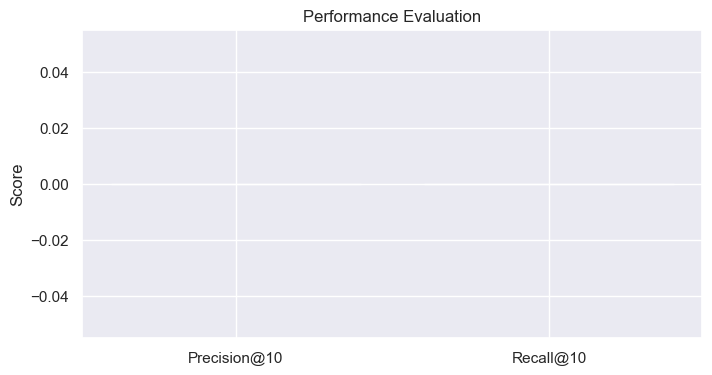

In [37]:
def plot_precision_recall(precision, recall):
    # Set up the matplotlib figure
    plt.figure(figsize=(8, 4))

    # Create an index for each tick position
    indices = np.arange(2)
    
    # Create the bar chart
    plt.bar(indices, [precision, recall], color=['blue', 'green'])

    # Add title and labels
    plt.title('Performance Evaluation')
    plt.ylabel('Score')
    plt.xticks(indices, ['Precision@10', 'Recall@10'])

    # Show the plot
    plt.show()

# Now you can call this function with the precision and recall values
plot_precision_recall(precision, recall)